# Complete guide

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



import trecs
from trecs.models import ContentFiltering, ImplicitMF
from trecs.random import Generator
from trecs.metrics import MSEMeasurement, RecSimilarity, InteractionSimilarity, RecallMeasurement
from trecs.components import Users
import trecs.matrix_ops as mo #Note, in order for the ideal recommender to result in non-insane results, the normalize_users parameter in mo.inner_product must be set to False

In [2]:
class IdealRecommender(ContentFiltering):
    """
    With the Ideal Recommender, we make the *strong assumption* that the true scores are provided
    to the recommender system through a custom scoring function, which always returns the true
    underlying user-item scores. Therefore, this class is pretty much an empty skeleton; the only
    modification is that we don't update any internal state of the recommender at each time step.
    
    Amy: Note to self, as a part of the baseline ContentFiltering class, if an actual_item_representation 
    """
    def __init__(self, *args, **kwargs):
        
        
        super().__init__(*args, **kwargs)
    

    def _update_internal_state(self, interactions):
        # do not change users_hat!
        pass


In [ ]:
#np.random.seed(1)
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 50})

In [9]:
# Keep the dimensions small for easy visualization
number_of_users = 50
number_of_attributes = 10
number_of_items = 150
# We define user_representation using the standard integer generator in Numpy.
# We assume a number of interactions with each attribute in the interval [0,4).

users_shape = (number_of_users, number_of_attributes)
actual_user_representation = Users(size=users_shape, num_users=number_of_users)
model_user_representation = np.random.randint(4, size=(number_of_users, number_of_attributes))

# We define item_representation using the Generator that comes with the framework
# We assume a binary matrix with a binomial distribution

actual_item_representation = Generator().binomial(
    n=1, p=.3, size=(number_of_attributes, number_of_items)
)

model_item_representation = Generator().binomial(
    n=1, p=.3, size=(number_of_attributes, number_of_items)
)

In [10]:
#Not positive this is correct

content = ContentFiltering(
    num_users=number_of_users,
    num_items=number_of_items,
    num_attributes=number_of_attributes,
    actual_user_representation=actual_user_representation,
    user_representation=model_user_representation, 
    actual_item_representation = actual_item_representation,
    item_representation=actual_item_representation, #model has the true item values
)
# add an MSE measurement
content.add_metrics(MSEMeasurement(), RecallMeasurement())
# Run for 5 time steps
content.run(timesteps=5)

100%|██████████| 5/5 [00:00<00:00, 73.27it/s]


In [7]:
ideal = IdealRecommender(
    num_users=number_of_users,
    num_items=number_of_items,
    num_attributes=number_of_attributes,
    actual_user_representation=actual_user_representation,
    user_representation=actual_user_representation.actual_user_profiles.value, 
    actual_item_representation = actual_item_representation,
    item_representation=actual_item_representation, #model has the true item values
    num_items_per_iter="all",
)
# add an MSE measurement
ideal.add_metrics(MSEMeasurement(), RecallMeasurement())
# Run for 5 time steps
ideal.run(timesteps=5)

100%|██████████| 5/5 [00:00<00:00, 1643.54it/s]


In [20]:
mf = ImplicitMF(
    num_users=number_of_users,
    num_items=number_of_items,
    num_latent_factors=number_of_attributes,
    actual_user_representation=actual_user_representation,
    actual_item_representation = actual_item_representation,
)
# add an MSE measurement
mf.add_metrics(MSEMeasurement(), RecallMeasurement())
# Run for 5 time steps
mf.run(timesteps=5)

100%|██████████| 5/5 [00:00<00:00, 213.77it/s]


In [21]:
# Collect measurements about the simulation
results = mf.get_measurements()

print("Results of the simulation:")
pd.DataFrame(results)

Results of the simulation:


,mse,recall_at_k,timesteps
0,1.311667,NaN,0
1,1.311667,0.12,1
2,1.311667,0.12,2
3,1.311667,0.12,3
4,1.311667,0.12,4
5,1.311667,0.12,5


In [8]:
# Collect measurements about the simulation
results = ideal.get_measurements()

print("Results of the simulation:")
pd.DataFrame(results)

Results of the simulation:


,mse,recall_at_k,timesteps
0,0.0,NaN,0
1,0.0,1.0,1
2,0.0,1.0,2
3,0.0,1.0,3
4,0.0,1.0,4
5,0.0,1.0,5


In [ ]:
results = content.get_measurements()

print("Results of the simulation:")
pd.DataFrame(results)

In [ ]:
#generate a distribution that hides a subpopulation
number_of_attributes = 10
number_of_maj_users = 150
number_of_min_users = 50

maj_user_representation = np.random.normal(1, 2, size=(number_of_maj_users, number_of_attributes))
min_user_representation = np.random.normal(0.5, 1.25, size=(number_of_min_users, number_of_attributes))
actual_user_representation = np.vstack((maj_user_representation, min_user_representation))
split_indices=number_of_maj_users

In [ ]:
#If plotted without respect to the subgroups, preference means look more or less normally distributed
plt.hist(actual_user_representation.mean(axis=1))



In [ ]:
#when plotting out mean preferences when accounting for group, we can see a clear distinction in preference
plt.hist(maj_user_representation.mean(axis=1), alpha=.7, color='b')
plt.hist(min_user_representation.mean(axis=1), alpha=0.7, color='r')



In [ ]:
filtering = ContentFiltering(actual_user_representation=actual_user_representation, 
                             num_attributes=number_of_attributes,
                             num_items=500)


mse = MSEMeasurement(diagnostics=True)
recall=RecallMeasurement()

filtering.add_metrics(mse, recall)

filtering.startup_and_train(50)
filtering.run(450)

In [ ]:
mse_diagnostics = filtering.metrics[0].get_diagnostics()
mse_beginning = mse_diagnostics.loc[50:, :]
mse_beginning.head()



In [11]:
def mse_histogram(model, split_indices=None):
    metric = (
                model.predicted_scores.value.mean(axis=1)- model.users.actual_user_scores.value.mean(axis=1))** 2
    
    colors = ["blue", "orange", "red", "yellow", "green"]
    if split_indices is not None and len(split_indices) > 0:
        splits = [0] + split_indices + [metric.size]
        for i in range(len(splits) - 1):
            values = metric[splits[i] : splits[i + 1]]
            plt.hist(values, alpha=0.7, color=colors[i])
    else:
        plt.hist(metric, bins="auto")
        plt.ylabel("observation count (total n={})".format(metric.size))
        plt.xlabel("mean sqaured error")

In [31]:
mf.startup_and_train(50)


100%|██████████| 50/50 [00:00<00:00, 666.83it/s]


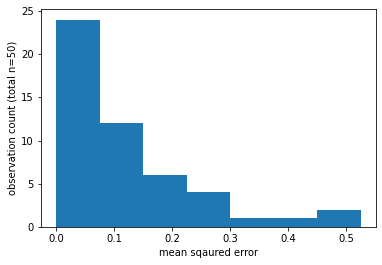

In [32]:
mse_histogram(mf)

100%|██████████| 50/50 [00:00<00:00, 337.65it/s]


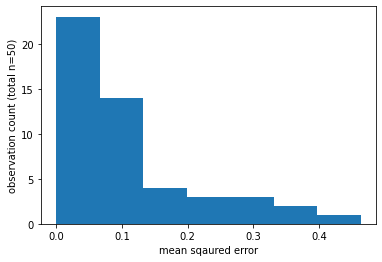

In [33]:
mf.run(50)
mf.train()
mse_histogram(mf)

100%|██████████| 50/50 [00:00<00:00, 334.50it/s]


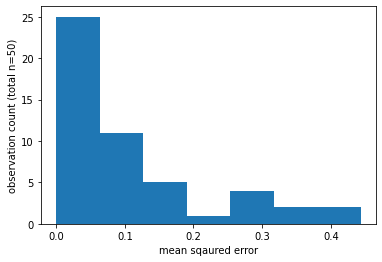

In [34]:
mf.run(50)
mf.train()
mse_histogram(mf)

100%|██████████| 50/50 [00:00<00:00, 330.18it/s]


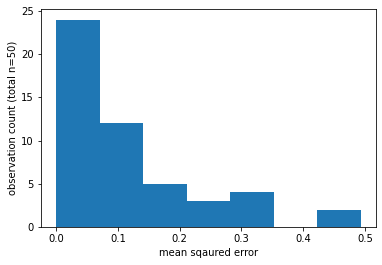

In [35]:
mf.run(50)
mf.train()
mse_histogram(mf)

100%|██████████| 50/50 [00:00<00:00, 109.81it/s]


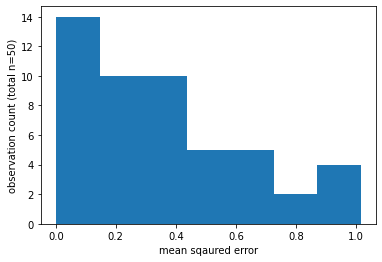

In [17]:
content.run(50)
mse_histogram(content)

100%|██████████| 50/50 [00:00<00:00, 109.37it/s]


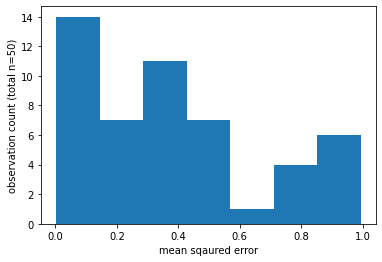

In [18]:
content.run(50)
mse_histogram(content)

In [ ]:
print(in_k)
print(not_in_k)
print(len(model.interactions))
k

In [ ]:

np.concatenate((np.ones(len(in_k)), np.zeros(len(not_in_k))), axis=None)

In [ ]:
colors = ["blue", "orange", "red", "yellow", "green"]
split_indices = number_of_maj_users
shown_item_scores = np.take(model.predicted_scores.value, model.items_shown)
shown_item_ranks = np.argsort(shown_item_scores, axis=1)
top_k_items = np.take(model.items_shown, shown_item_ranks[:, k :])
in_k = (np.where(np.isin(model.interactions, top_k_items))[0])
not_in_k = (np.where(~np.isin(model.interactions, top_k_items))[0])
metric = np.concatenate((np.ones(len(in_k)), np.zeros(len(not_in_k))), axis=None)

maj_population_outcomes = metric[:split_indices]
min_population_outcomes = metric[split_indices:]

plt.hist(maj_population_outcomes, color=colors[0])
plt.hist(min_population_outcomes, color=colors[1])



# if split_indices is not None:
#     splits = [0] + split_indices + [metric.size]
#     for i in range(len(splits) - 1):
#         values = metric[splits[i] : splits[i + 1]]
#         plt.hist(values, alpha=0.7, color=colors[i])

# plt.hist(metric, bins="auto")
# plt.ylabel("observation count (total n={})".format(metric.size))
# plt.xlabel("recall at k")


# 
#     if split_indices is not None and len(split_indices) > 0:
#         splits = [0] + split_indices + [metric.size]
#         for i in range(len(splits) - 1):
#             values = metric[splits[i] : splits[i + 1]]
#             plt.hist(values, alpha=0.7, color=colors[i])
#     else:
#         plt.hist(metric, bins="auto")
#         plt.ylabel("observation count (total n={})".format(metric.size))
#         plt.xlabel("mean sqaured error")

In [ ]:
plt.hist(min_population_outcomes)

In [ ]:
len(min_population_outcomes)

In [ ]:
metric_histogram(filtering)

In [ ]:
metric_histogram(filtering, [number_of_maj_users])

In [ ]:
#generate a bimodal distribution
N=500
mu, sigma = 1.845, 1
mu2, sigma2 = 5.845, 1
X1 = np.random.normal(mu, sigma, N)
X2 = np.random.normal(mu2, sigma2, N)
X_bimodal = np.concatenate([X1, X2])

In [ ]:
# print majority / minority outcome stats
def majority_minority_outcomes(metric, split_index):
    split_indices = [split_index]

        
    maj_mean = metric.last_observation[:split_index].mean()
    maj_std = metric.last_observation[:split_index].std()

    min_mean = metric.last_observation[split_index:].mean()
    min_std = metric.last_observation[split_index:].std()

    print("Majority group statistics: ", maj_mean, "(mean), ", maj_std, "(std)")
    print("Minority group statistics: ", min_mean, "(mean), ", min_std, "(std)")
    print()
    
    metric.hist(split_indices)

In what follows, we expand on this minimal example to gain a deeper understanding of what happens under the hood.

In [ ]:
filtering = ContentFiltering(actual_user_representation=actual_user_representation, 
                             num_attributes=number_of_attributes,
                             num_items=500)


mse = MSEMeasurement(diagnostics=True)
filtering.add_metrics(mse)

filtering.startup_and_train(50)
majority_minority_outcomes(mse, number_of_maj_users)


In [ ]:
filtering.run(450)
majority_minority_outcomes(mse, number_of_maj_users)

In [ ]:
bimodal = plt.hist(X_bimodal, bins=30)
plt.xlabel('Dependent Variable Value')
plt.ylabel('Number of Observations')
plt.title('Bimodal Distribution')
plt.show()

In [ ]:
print(np.mean(X_bimodal))
print(np.std(X_bimodal))

In [ ]:
N=1000
mu, sigma = 14.99, 4
X1 = np.random.normal(mu, sigma, N)
X_skew = np.log2(X1)

skew = plt.hist(X_skew, bins=30)
plt.xlabel('Dependent Variable Value')
plt.ylabel('Number of Observations')
plt.title('Skewed Distribution')
plt.show()

In [ ]:
N=1000
mu, sigma = 3.85, 2.2
normal_dist = np.random.normal(mu, sigma, N)

skew = plt.hist(normal_dist, bins=30)
plt.xlabel('Dependent Variable Value')
plt.ylabel('Number of Observations')
plt.title('Normal Distribution')
plt.show()

In [ ]:
#How to characterize power, type 1 vs type 2 errors 